Licensed to the Apache Software Foundation (ASF) under one
or more contributor license agreements.  See the NOTICE file
distributed with this work for additional information
regarding copyright ownership.  The ASF licenses this file
to you under the Apache License, Version 2.0 (the
"License"); you may not use this file except in compliance
with the License.  You may obtain a copy of the License at

  http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an
"AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
KIND, either express or implied.  See the License for the
specific language governing permissions and limitations
under the License.

# Household Power Consumption

In [1]:
import os
import math

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import cluster
from sklearn import neighbors

import torch
import torch.nn as nn
import torch.optim as optim

import scikit_wrappers

In [2]:
cuda = False
if torch.cuda.is_available():
    print("Using CUDA...")
    cuda = True

# GPU number
gpu = 0

Using CUDA...


## Dataset

The dataset can be found here: [https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption).

In [3]:
# Path to dataset
data = 'Time Series/household_power_consumption.txt'

In [4]:
# Dataset as a dataframe
df = pd.read_csv(data, sep=';', decimal=',')

In [5]:
# Replace missing values by the last seen values
dataset = np.transpose(np.array(df))[2].reshape(1, 1, -1)
for i in range(np.shape(dataset)[2]):
    if dataset[0, 0, i] == '?':
        dataset[0, 0, i] = dataset[0, 0, i-1]
dataset = dataset.astype(float)

# Training and testing partition (training set: first 1500000 measurements)
train = dataset[:, :, :500000]
test = dataset[:, :, 500000:]

In [6]:
# Preprocessing: normalization
mean = np.mean(dataset)
var = np.var(dataset)

dataset = (dataset - mean)/math.sqrt(var)
train = (train - mean)/math.sqrt(var)
test = (test - mean)/math.sqrt(var)

print('Mean: ', np.mean(dataset))
print('Variance: ', np.var(dataset))

Mean:  1.5317047090008447e-16
Variance:  0.9999999999999999


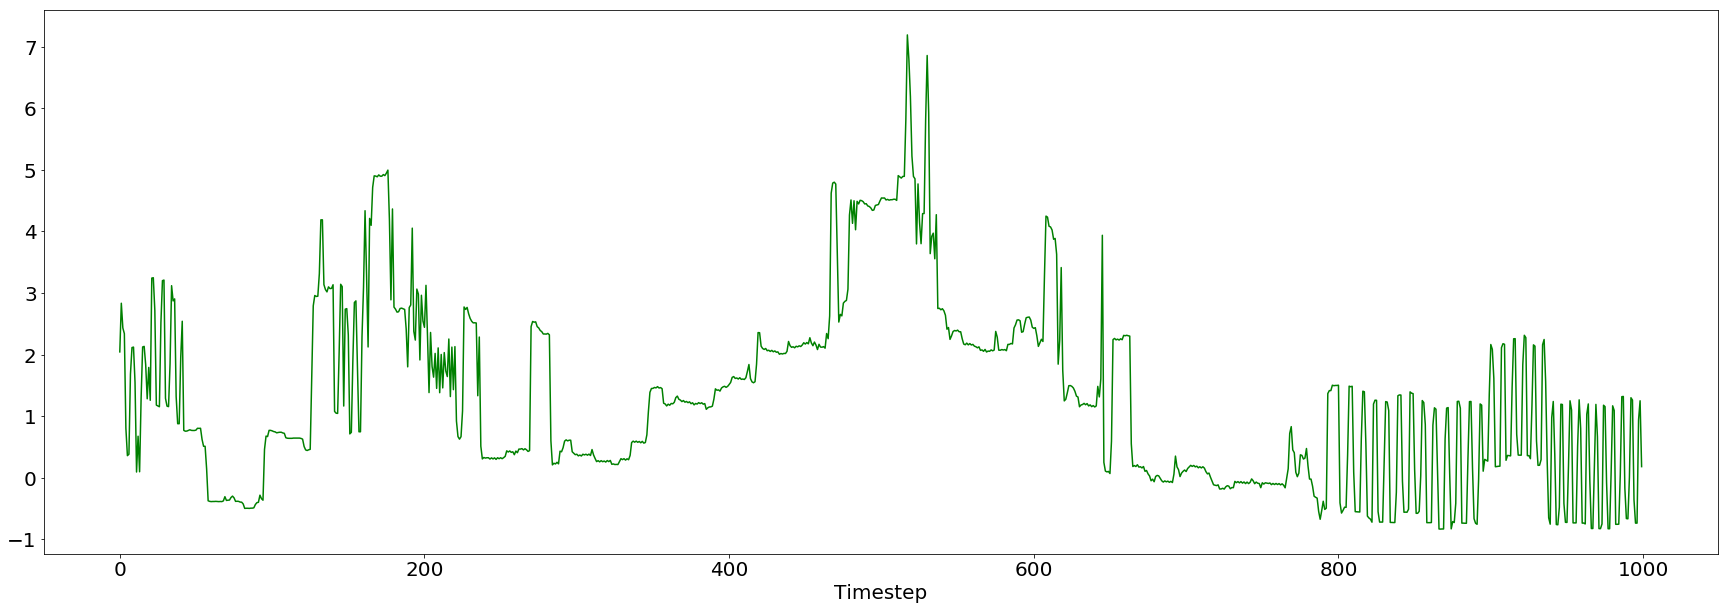

In [7]:
plt.figure(figsize=(30,10))
plt.xlabel('Timestep', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(dataset[0, 0, 50000:51000], color='g')
plt.show()
plt.close()

## Feature Learning (Yearly Scale)

### Learning Parameters

In [13]:
# Set to True to train a new model
training = False

# Prefix to path to the saved model
model = 'Time Series/HouseholdPowerConsumption_yearly'

In [14]:
hyperparameters = {
    "batch_size": 1,
    "channels": 30,
    "compared_length": None,
    "depth": 10,
    "nb_steps": 400,
    "in_channels": 1,
    "kernel_size": 3,
    "penalty": None,
    "early_stopping": None,
    "lr": 0.001,
    "nb_random_samples": 10,
    "negative_penalty": 1,
    "out_channels": 160,
    "reduced_size": 80,
    "cuda": cuda,
    "gpu": gpu
}

### Training

In [15]:
encoder_yearly = scikit_wrappers.CausalCNNEncoderClassifier()
encoder_yearly.set_params(**hyperparameters)

CausalCNNEncoderClassifier(batch_size=1, channels=30, compared_length=inf,
              cuda=True, depth=10, early_stopping=None, epochs=400, gpu=0,
              in_channels=1, kernel_size=3, lr=0.001, nb_random_samples=10,
              negative_penalty=1, out_channels=160, penalty=None,
              reduced_size=80)

In [16]:
if training:
    encoder_yearly.fit_encoder(train, save_memory=True, verbose=True)
    encoder_yearly.save_encoder(model)
else:
    encoder_yearly.load_encoder(model)

In [17]:
torch.cuda.empty_cache()

## Computing Representations
We compute in the following (or load them from local storage if they are already precomputed) the learned representations given by the yearly encoder on sliding windows of different sizes (a week, a quarter) for the whole dataset.

In [18]:
compute_representations = False
storage_train_day = 'Time Series/HouseholdPowerConsumption_representations_train_yearly_day.npy'
storage_test_day = 'Time Series/HouseholdPowerConsumption_representations_test_yearly_day.npy'
storage_train_quarter = 'Time Series/HouseholdPowerConsumption_representations_train_yearly_quarter.npy'
storage_test_quarter = 'Time Series/HouseholdPowerConsumption_representations_test_yearly_quarter.npy'

In [19]:
if compute_representations:
    train_features_day = encoder_yearly.encode_window(train, 1440)
    np.save(storage_train_day, train_features_day)
    test_features_day = encoder_yearly.encode_window(test, 1440)
    np.save(storage_test_day, test_features_day)
    train_features_quarter = encoder_yearly.encode_window(train, 12*7*1440, batch_size=25)
    np.save(storage_train_quarter, train_features_quarter)
    test_features_quarter = encoder_yearly.encode_window(test, 12*7*1440, batch_size=25)
    np.save(storage_test_quarter, test_features_quarter)
else:
    train_features_day = np.load(storage_train_day)
    test_features_day = np.load(storage_test_day)
    train_features_quarter = np.load(storage_train_quarter)
    test_features_quarter = np.load(storage_test_quarter)

## Visualization

In [15]:
# From http://abhay.harpale.net/blog/python/how-to-plot-multicolored-lines-in-matplotlib/
# to plot multicolored cruves in matplotlib
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs

In [16]:
kmeans = cluster.KMeans(n_clusters=6).fit(np.swapaxes(test_features_day[0, :, 76+5*1440:76+6*1440], 0, 1))

No handles with labels found to put in legend.


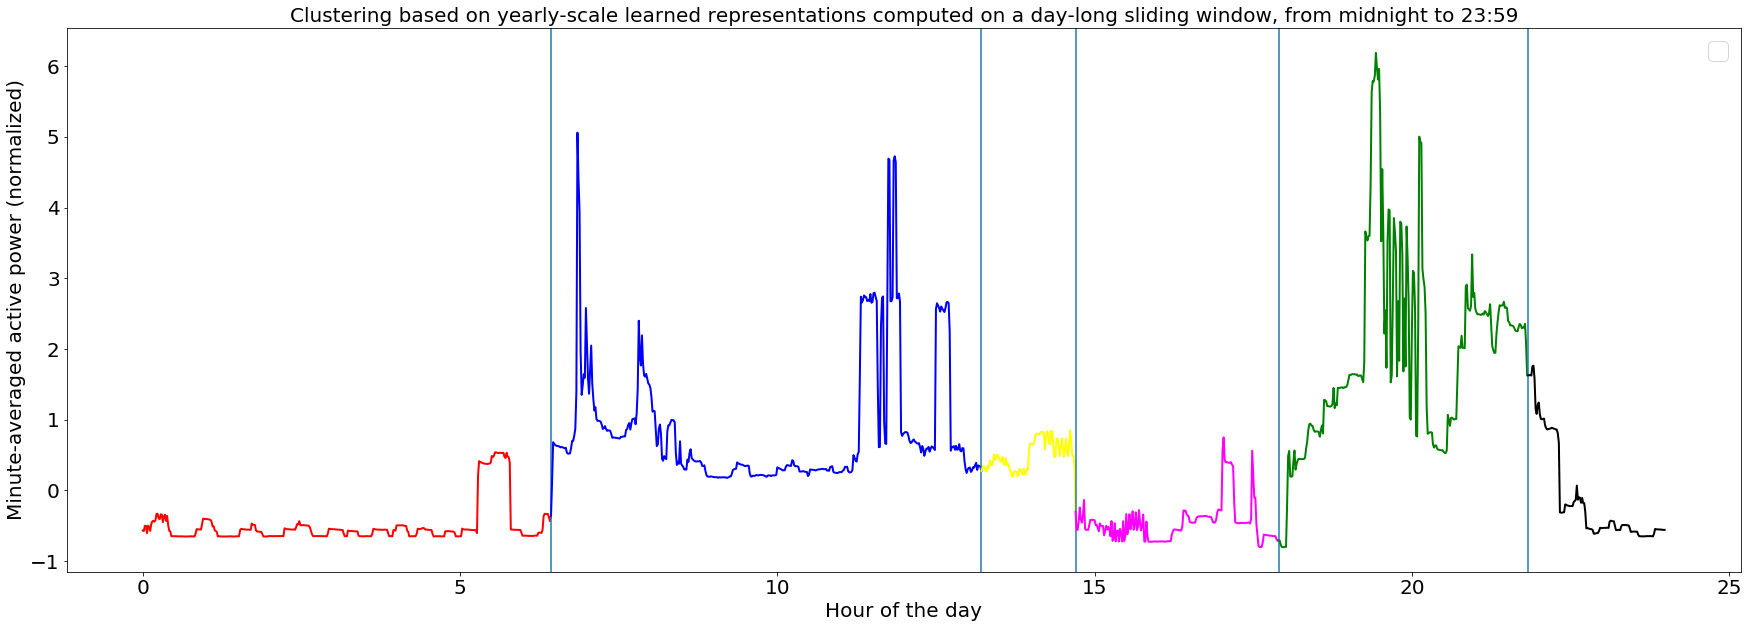

In [17]:
plt.figure(figsize=(30,10))
plt.title('Clustering based on yearly-scale learned representations computed on a day-long sliding window, from midnight to 23:59', fontsize=20)
plt.xlabel('Hour of the day', fontsize=20)
plt.ylabel('Minute-averaged active power (normalized)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
associated_colors = {0: 'blue', 1: 'green', 2: 'red', 3: 'yellow', 4: 'magenta', 5: 'black', 6: 'purple', 7: 'cyan', 8: 'pink', 9: 'orange', 10: 'grey', 11: 'fuchsia', 12: 'maroon', 13: 'navy'}
colors = [associated_colors[l] for l in kmeans.labels_]
segments = find_contiguous_colors(colors)
start = 76+6*1440
beginning = True
for seg in segments:
    end = start + len(seg)
    if beginning:
        hour_range = ((np.arange(start, end) - 76)%1440)/60
        l, = plt.gca().plot(hour_range, test[0, 0, start:end], lw=2, c=seg[0]) 
        beginning = False
    else:
        hour_range = ((np.arange(start-1, end) - 76)%1440)/60
        plt.gca().axvline(x=hour_range[0])
        l, = plt.gca().plot(hour_range, test[0, 0, start-1:end], lw=2, c=seg[0]) 
    start = end
plt.legend(fontsize=25)
plt.savefig('electricity.eps')

## Evaluation

In [20]:
# Training and testing sets as PyTorch variables
train_features_day = torch.from_numpy(train_features_day)
test_features_day = torch.from_numpy(test_features_day)
train_features_quarter = torch.from_numpy(train_features_quarter)
test_features_quarter = torch.from_numpy(test_features_quarter)
train = torch.from_numpy(train)
test = torch.from_numpy(test)
if torch.cuda.is_available():
    train_features_day = train_features_day.cuda(gpu)
    test_features_day = test_features_day.cuda(gpu)
    train_features_quarter = train_features_quarter.cuda(gpu)
    test_features_quarter = test_features_quarter.cuda(gpu)
    train = train.cuda(gpu)
    test = test.cuda(gpu)

### Regression / Forecasting (24h)

The task here is to predict the evolution of the average electricity consumption for the next 24 hours, compared to the one of the last 24 hours.

In [38]:
# Computing values to predict
means = np.array(pd.DataFrame(data=dataset[0, 0]).rolling(1440).mean())[:, 0]
target = -means[:-1439] + means[1439:]
train_target = target[1439:500000]
test_target = target[500000+1439:]

In [39]:
# Transferring targets to PyTorch tensors
train_target = torch.from_numpy(train_target)
test_target = torch.from_numpy(test_target)
if torch.cuda.is_available():
    train_target = train_target.cuda(gpu)
    test_target = test_target.cuda(gpu)

#### Linear Regression using Learned Representations

We use representations computed by the learned encoder on a day-long sliding window.

In [40]:
regressor = nn.Linear(160, 1)
regressor.double()
if torch.cuda.is_available():
    regressor.cuda(gpu)
loss = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters(), lr=0.001)
epochs = 400

In [41]:
%%time
for i in range(epochs):
    l = loss(regressor(train_features_day[0].t()).squeeze(), train_target)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
print("end")

end
CPU times: user 8.48 s, sys: 3.57 s, total: 12.1 s
Wall time: 12.1 s


In [42]:
with torch.no_grad():
    print(loss(regressor(test_features_day[0, :, :-1439].t()).squeeze(), test_target).data.cpu().numpy())

0.08951327073870838


#### Linear Regression using the Raw Values of the Last 24 hours

In [36]:
regressor = nn.Conv1d(1, 1, 1440)
regressor.double()
if torch.cuda.is_available():
    regressor.cuda(gpu)
loss = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters(), lr=0.0001)
epochs = 400

In [25]:
%%time
for i in range(epochs):
    l = loss(regressor(train).squeeze(), train_target)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
print("end")

end
CPU times: user 2min, sys: 1min, total: 3min 1s
Wall time: 3min 1s


In [26]:
with torch.no_grad():
    print(loss(regressor(test).squeeze()[:-1439], test_target).data.cpu().numpy())

0.08915801725356748


### Regression / Forecasting (a Quarter)

The task here is to predict the evolution of the average electricity consumption for the next quarter, compared to the one of the last quarter.

In [43]:
# Computing values to predict
means = np.array(pd.DataFrame(data=dataset[0, 0]).rolling(7*12*1440).mean())[:, 0]
target = -means[:-7*12*1440 + 1] + means[7*12*1440 - 1:]
train_target = target[7*12*1440 - 1:500000]
test_target = target[500000 + 7*12*1440 - 1:]

In [44]:
# Transferring targets to PyTorch tensors
train_target = torch.from_numpy(train_target)
test_target = torch.from_numpy(test_target)
if torch.cuda.is_available():
    train_target = train_target.cuda(gpu)
    test_target = test_target.cuda(gpu)

#### Linear Regression using Learned Representations

We use representations computed by the learned encoder on a quarter-long sliding window.

In [45]:
regressor = nn.Linear(160, 1)
regressor.double()
if torch.cuda.is_available():
    regressor.cuda(gpu)
loss = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters(), lr=0.0001)
epochs = 400

In [46]:
%%time
for i in range(epochs):
    l = loss(regressor(train_features_quarter[0].t()).squeeze(), train_target)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
print("end")

end
CPU times: user 6.56 s, sys: 2.72 s, total: 9.28 s
Wall time: 9.28 s


In [47]:
with torch.no_grad():
    print(loss(regressor(test_features_quarter[0, :, :-7*12*1440 + 1].t()).squeeze(), test_target).data.cpu().numpy())

0.07255152957379928


#### Linear Regression using the Raw Values of the Last Quarter

In [32]:
regressor = nn.Conv1d(1, 1, 1440*7*12)
regressor.double()
if torch.cuda.is_available():
    regressor.cuda(gpu)
loss = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters(), lr=0.001)
epochs = 400

In [33]:
%%time
for i in range(epochs):
    l = loss(regressor(train).squeeze(), train_target)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
print("end")

end
CPU times: user 1h 6min 40s, sys: 33min 37s, total: 1h 40min 17s
Wall time: 1h 40min 15s


In [34]:
with torch.no_grad():
    print(loss(regressor(test).squeeze()[:-7*12*1440 + 1], test_target).data.cpu().numpy())

0.06257629058462644
